<a href="https://colab.research.google.com/github/satyagopalkothuru/machine_learning_colab_experiments/blob/master/cifar_100_resnet18_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchsummary
import torch.nn as nn

import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from tqdm.notebook import tqdm
import warnings
from google.colab import files
import copy

In [30]:
warnings.filterwarnings("ignore")
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
device

device(type='cuda')

In [32]:
#transformations
train_transform= transforms.Compose([
                                    transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485,0.456,0.406],
                                                         std=[0.229,0.224,0.225])
])

test_transform= transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485,0.456,0.406],
                                                         std=[0.229,0.224,0.225])
])

In [33]:
train_data=datasets.CIFAR100(train=True,
                             download=True,
                             root='./data',
                             transform=train_transform)

test_data=datasets.CIFAR100(train=False,
                             download=True,
                             root='./data',
                             transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
classes=train_data.classes
print(classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [35]:
print('Train dataset size:',len(train_data))
print('Test dataset size:',len(test_data))

Train dataset size: 50000
Test dataset size: 10000


In [36]:
train_loader= DataLoader(train_data,
                         batch_size=4,
                         shuffle=True)

test_loader= DataLoader(test_data,
                         batch_size=4,
                         shuffle=False)

In [37]:
def show_imgs(imgs, title):
    imgs=imgs.cpu()
    mean=torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
    std=torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)

    imgs=imgs*std+mean #un-normalizing the images
    img_grid=torchvision.utils.make_grid(imgs, nrow=4)
    img_np=img_grid.numpy()
    img_np=np.transpose(img_np, (1,2,0))

    plt.figure(figsize=(8,4))
    plt.imshow(img_np)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.plot()

Training Examples:


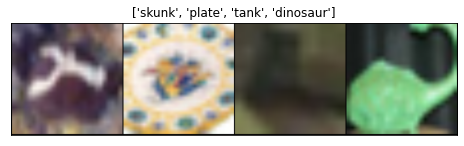

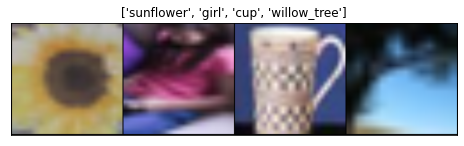

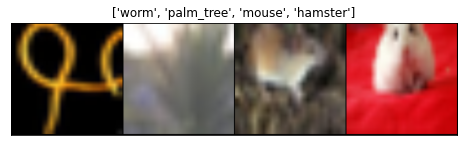

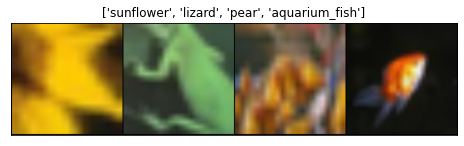

In [38]:
#printing some of training examples
print('Training Examples:')

for i, batch in enumerate(train_loader):
    if i==4:
        break
    images, labels= batch
    show_imgs(images, str([classes[i] for i in labels]))

In [39]:
#loading a pre-trained model
resnet=torchvision.models.resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
torchsummary.summary(resnet.to(device), input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [14]:
print(resnet.layer1)
print(resnet.layer2)
print(resnet.layer3)
print(resnet.layer4)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128,

In [15]:
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [40]:
#modifying the classifier's output layer
in_features=resnet.fc.in_features

modified_classifier=list(resnet.fc.children())[:-1]
modified_classifier.append(nn.Linear(in_features, 100))

modified_classifier

[Linear(in_features=512, out_features=100, bias=True)]

In [41]:
resnet.fc=nn.Sequential(*modified_classifier)

resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
#freezing the conv layers and hidden fc layers

for param in resnet.parameters():
    param.requires_grad= False

In [43]:
for param in resnet.fc.parameters():
    param.requires_grad=True

In [44]:
for param in resnet.parameters():
    if param.requires_grad== True:
        print(param.size())

torch.Size([100, 512])
torch.Size([100])


In [45]:
#training

def evaluate(model, dataloader):
    total,correct =0,0

    #setting the model to eval mode
    #turns off batchnorm and dropout

    for batch in dataloader:
        images, labels= batch
        images, labels= images.to(device), labels.to(device)

        outs= model(images)
        out_labels = torch.argmax(outs, axis=1)

        total += labels.size(0)
        correct += (labels == out_labels).sum().item()
    return 100* correct/total

In [25]:
#training with model checkpoints

def train(model, modelname, loss_fn, optimizer, train_loader, test_loader, epochs):
    hist={'epoch_loss':[],
          'train_acc':[],
          'test_acc':[]}

    min_loss=10000
    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training last layer'):
        losses=[]

        for batch in train_loader:
            images, labels = batch
            images, labels= images.to(device), labels.to(device)

            model.train()

            outs=model(images)
            loss= loss_fn(outs, labels)

            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            del images, labels, outs
            torch.cuda.empty_cache()

        
        curr_epoch_loss =np.array(losses).mean()
        hist['epoch_loss'].append(curr_epoch_loss)
        hist['train_acc'].append(evaluate(model, train_loader))
        hist['test_acc'].append(evaluate(model, test_loader))

        if curr_epoch_loss<min_loss:
            min_loss=curr_epoch_loss
            best_model=copy.deepcopy(model.state_dict())

    print("Plotting your graphs...")
    fig,ax=plt.subplots(ncols=2, figsize=(12, 6))
    ax[0].plot(range(1, epochs+1), hist['epoch_loss'], label='Loss')
    ax[0].plot(range(1, epochs+1), np.ones(epochs)*min_loss, 'r--', alpha=0.6, label='Min loss={}'.format(min_loss))
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss Value')
    ax[0].set_title('Epochs vs. Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, epochs+1),hist['train_acc'], "b--",alpha=0.8, label='Training Accuracy')
    ax[1].plot(range(1, epochs+1),hist['test_acc'], 'r--',alpha=0.8, label="Test accuracy")
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Epochs vs. Accuracy')
    ax[1].grid()
    ax[1].legend()
    plt.plot()

    print("Saving your best model...")
    torch.save(best_model, '{0}_{1:.4f}.pth'.format(modelname, min_loss))
    print("Best loss value: {}".format(min_loss))
    print("Downloading your best model...")
    #files.download('{0}_{1:.4f}.pth'.format(modelname, min_loss))
    print("Returning your best model...")
    return best_model


In [46]:
train_loader= DataLoader(train_data,
                         batch_size=16,
                         shuffle=True)

test_loader= DataLoader(test_data,
                         batch_size=16,
                         shuffle=False)


Plotting your graphs...
Saving your best model...
Best loss value: 2.5378174753189087


MessageError: ignored

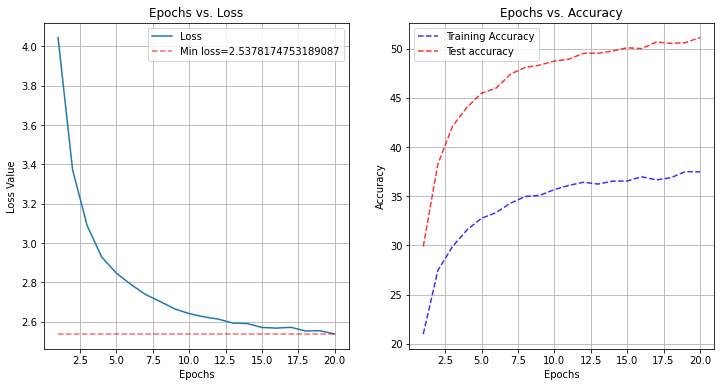

In [24]:
resnet=resnet.to(device)

opt=torch.optim.Adam(resnet.parameters(), lr=0.0001)
loss_fn=nn.CrossEntropyLoss()

vgg_wts=train(resnet, 'resnet', loss_fn, opt,train_loader, test_loader, 20)


Plotting your graphs...
Saving your best model...
Best loss value: 2.565686388511658
Returning your best model...


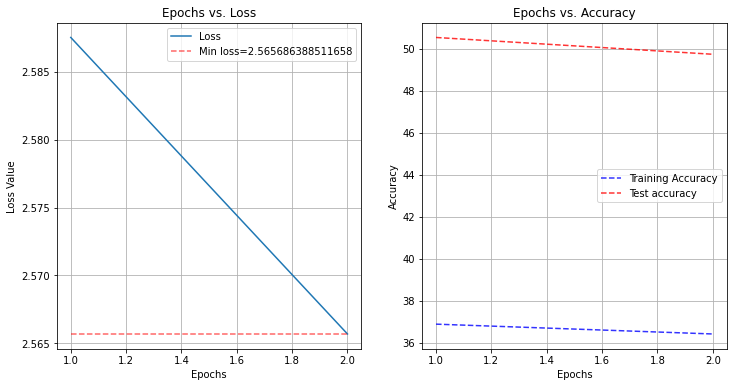

In [26]:

opt=torch.optim.Adam(resnet.parameters(), lr=0.0003)
loss_fn=nn.CrossEntropyLoss()

resnet_wts=train(resnet, 'resnet', loss_fn, opt,train_loader, test_loader, 2)


Plotting your graphs...
Saving your best model...
Best loss value: 2.49792436504364
Returning your best model...


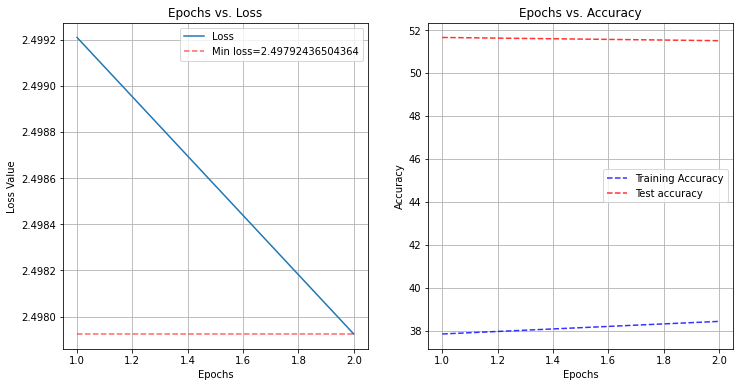

In [27]:

opt=torch.optim.Adam(resnet.parameters(), lr=0.00001)
loss_fn=nn.CrossEntropyLoss()

vgg_wts=train(resnet, 'resnet', loss_fn, opt,train_loader, test_loader, 2)

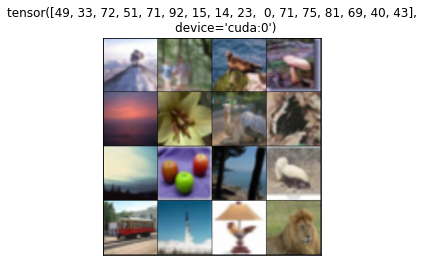

In [55]:
test_imgs, test_labels=next(iter(test_loader))
test_imgs, test_labels=test_imgs.to(device), test_labels.to(device)

show_imgs(test_imgs, test_labels)



In [56]:
print([classes[i] for i in [49, 33, 72, 51, 71, 92, 15, 14, 23, 0, 71, 75, 81, 69, 40, 43]])

['mountain', 'forest', 'seal', 'mushroom', 'sea', 'tulip', 'camel', 'butterfly', 'cloud', 'apple', 'sea', 'skunk', 'streetcar', 'rocket', 'lamp', 'lion']


In [ ]:
best_model=torchvision.models.resnet18()
best_model.load_state_dict(torch.load('resnet_2.4979.pth'))
best_model=best_model.to(device)
print(best_model)

In [ ]:
print('Test accuracy: {} \n Train accuracy: {}'.format(evaluate(best_model, test_loader), evaluate(best_model, train_loader)))